In [1]:
# basic IO, etc
import io, os, shutil

# pull locations from overpass
import overpy

# get location files
import requests

# math
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np

# geometry + data manipulation
import pandas as pd
import geopandas as gpd
import shapely
from pyproj import Proj, Transformer

# Used to do multi-processing
from multiprocessing import Pool
from functools import partial
from contextlib import contextmanager

# display  an image
from PIL import Image, ImageDraw
import IPython

In [2]:
@contextmanager
def poolcontext(*args, **kwargs):
    pool = Pool(*args, **kwargs)
    yield pool
    pool.terminate()

## Some Initial Set-Up

In [3]:
# number of processors
n_proc = 32 # Yay Ryzen 3950X (:

# create directories for input/output
os.makedirs("./data/", exist_ok=True)
os.makedirs("./output_nonsphere/", exist_ok=True)

# obtain the following geojson file of us states if not present
us_state_geojson_path = "./data/gz_2010_us_040_00_500k.json"
if not os.path.exists(us_state_geojson_path):
    url = "https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json"
    r = requests.get(url)
    open(us_state_geojson_path, 'wb').write(r.content)
    
# overpass URL
#overpass_url = "http://overpass-api.de/api/interpreter"
overpass_url = "http://localhost:8091/api/interpreter"

## Obtain Locations Using Overpass API

In [4]:
def get_fastfood_locations(fast_food_locations, url=overpass_url):    
    api = overpy.Overpass(url=url)
    
    result = api.query("""
    (
      node["brand"~"^{0}"]["amenity"~"fast_food|restaurant"];
      way["brand"~"^{0}"]["amenity"~"fast_food|restaurant"];
      relation["brand"~"^{0}"]["amenity"~"fast_food|restaurant"];
    );
    out body;
    """.format(fast_food_chain)
    )
    
    return result.nodes

In [5]:
fast_food_query_results = dict()

fast_food_chain_list = [
    "McDonald's", "Burger King", "Wendy's"
]

fast_food_chain_list_alnum = [''.join(e for e in fast_food_chain if e.isalnum()) for 
                              fast_food_chain in fast_food_chain_list]

for fast_food_chain, fast_food_chain_pretty in zip(fast_food_chain_list, fast_food_chain_list_alnum):
    # save lat/lon results here
    fast_food_chain_location_csv = "./output_nonsphere/{}_Locations.csv".format(fast_food_chain_pretty)
    
    if not os.path.exists(fast_food_chain_location_csv):
        # query overpass
        location_results = get_fastfood_locations(fast_food_chain)
        
        # parse lat/lon and save to dict
        location_results = np.array([(float(n.lat), float(n.lon)) for n in location_results])
        fast_food_query_results[fast_food_chain] = location_results
        
        # write to file
        locations_df = pd.DataFrame(location_results, columns = ['lat', 'lon'])
        locations_df.to_csv(fast_food_chain_location_csv, index=False)
        
    else:
        # read the pre-existing file
        fast_food_query_results[fast_food_chain] = pd.read_csv(fast_food_chain_location_csv).to_numpy()
    
    # what all did we find?
    print("Found {} locations for {}.".format(len(fast_food_query_results[fast_food_chain]), 
                                              fast_food_chain))

Found 3428 locations for McDonald's.
Found 1073 locations for Burger King.
Found 903 locations for Wendy's.


## Filter Locations to Lower 48 States

In [6]:
# US Map GeoJSON file obtained from: https://eric.clst.org/tech/usgeojson/
us_state_map = gpd.read_file(us_state_geojson_path)
us_state_map['lower_48'] = us_state_map['NAME'].apply(lambda x: x not in ['Alaska', 'Hawaii', 'Puerto Rico'])
us_state_map = us_state_map[us_state_map['lower_48'] == True]

# dissolve to get the states combined into one multi-polygon
usa_lower_48 = us_state_map.dissolve(by = 'lower_48')
usa_lower_48_latlon = usa_lower_48.iloc[0].geometry

# below we will do all computations in 4087
usa_lower_48 = usa_lower_48.to_crs(epsg = 4087)
usa_lower_48_geom = usa_lower_48.iloc[0].geometry

In [7]:
# convert from lat-lon to 4087 and back
transf_latlon_to_4087 = Transformer.from_crs('epsg:4326', 'epsg:4087')
transf_4087_to_latlon = Transformer.from_crs('epsg:4087', 'epsg:4326')

In [8]:
def point_in_poly(p, poly):
    return poly.contains(shapely.geometry.Point(p))

In [9]:
def filter_and_transform_latlon_to_lower48(lat_lons, n_proc = 1):
    lats = lat_lons[:,0]
    lons = lat_lons[:,1]
    ps = np.array([transf_latlon_to_4087.transform(lat, lon) for lat,lon in zip(lats, lons)])

    with poolcontext(processes = n_proc) as p:
        in_lower_48 = p.map(
            partial(point_in_poly, poly = usa_lower_48_geom), 
            ps
        )

    # Filter and transform
    lats = lats[in_lower_48]
    lons = lons[in_lower_48]   
    ps = ps[in_lower_48, :]
        
    return ps, lats, lons

## Compute McFarthest Points

In [10]:
# Obtain the coordinates from the exterior boundary of a (multi)polygon
def exterior_boundary_vertex_coords(poly):
    if isinstance(poly, shapely.geometry.multipolygon.MultiPolygon):
        points = []
        for polygon in poly:
            points.extend(polygon.exterior.coords[:-1])
    
    elif isinstance(poly, shapely.geometry.polygon.Polygon):
        points = poly.exterior.coords[:-1]
    
    return points

In [11]:
# Compute the polygon formed by intersecting the polygon formed by vertices with
# the (multi)polygon poly
def intersection_polygon(vertices, poly):
    # vertices for cell containing p
    qs = list(vertices)
    qs.append(qs[0])
    qs = np.array(qs)
    
    # compute intersection of poly with voronoi cell
    cell_p = shapely.geometry.Polygon(qs)
    cell_p = poly.intersection(cell_p)    
    
    return cell_p

In [12]:
# Compute the vertices of the polygon formed by intersecting the polygon formed 
# by the points in the vertices array with the (multi)polygon poly
def intersection_polygon_vertices(vertices, poly):
    # compute intersection of poly with voronoi cell
    cell_p = intersection_polygon(vertices, poly)
    
    # vertices of intersection of p with poly
    restricted_cell_vertices = np.array(exterior_boundary_vertex_coords(cell_p))    
    
    return restricted_cell_vertices

In [13]:
def haversine_distance(coords1, coords2):
    earth_radius = 3958.8    
    
    lat1, lon1 = transf_4087_to_latlon.transform(coords1[:,0], coords1[:,1])
    lat2, lon2 = transf_4087_to_latlon.transform(coords2[:,0], coords2[:,1])
    
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    dist = earth_radius * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
    
    return dist

In [14]:
# Compute the maximum distance between p and any point in the vertices array
def max_dist_pt_to_verts(p, vertices):
    #distance_p_to_ext = np.linalg.norm(vertices - p, axis = 1)
    distance_p_to_ext = haversine_distance(vertices, p.reshape((1, 2)))
    idx_max = np.argmax(distance_p_to_ext)    
    max_distance = distance_p_to_ext[idx_max]
    arg_max_coords = vertices[idx_max]
    
    return max_distance, arg_max_coords

In [15]:
def mcfarthest_in_poly(ps, poly, n_proc = 1):
    # Get ranges of points
    xs, ys = ps[:,0], ps[:, 1]
    xmin, xmax = np.min(xs), np.max(xs)
    ymin, ymax = np.min(ys), np.max(ys)
    width  = xmax - xmin
    height = ymax - ymin

    # compute some points at "infinity" as a hack to "handle" unbounded regions:
    #    https://stackoverflow.com/a/57074133/3677367
    far_away_pts = np.array([
        np.array([xmin - 1000 * width, ymin - 1000 * height]), 
        np.array([xmax + 1000 * width, ymin - 1000 * height]),
        np.array([xmax + 1000 * width, ymax + 1000 * height]),
        np.array([xmax - 1000 * width, ymax + 1000 * height])    
    ])
    
    # extend the original points with the points at "infinity" for plotting
    ps_with_far_pts = np.concatenate([np.copy(ps), far_away_pts], axis = 0)
        
    # compute the voronoi diagram
    vor = Voronoi(ps_with_far_pts)        
   
    # extract information from voronoi diagram
    vor_points = vor.points
    vor_p_regions = vor.point_region
    vor_cell_vertices = [np.array([vor.vertices[l] for l in vor.regions[idx_p_region]]) 
                         for idx_p_region in list(vor_p_regions)]
    
    # restrict the vertices to the polygon
    # may be slow, so we run with multiprocessing
    with poolcontext(processes = n_proc) as p:
        restricted_cell_vertices = p.map(
            partial(intersection_polygon_vertices,
                    poly=poly
            ), 
            list(vor_cell_vertices)
        )
    
    # compute results
    cell_max_distance_vertex_pairs = [max_dist_pt_to_verts(p, cell) for p, cell in 
                                      zip(ps, restricted_cell_vertices[:len(ps)]) 
                                      if len(cell) > 0]
    max_distance_idx = np.argmax([d for d,p in cell_max_distance_vertex_pairs])
    max_distance, mcfarthest = cell_max_distance_vertex_pairs[max_distance_idx]
    nearest_pt = ps[max_distance_idx, :]
    
    return max_distance, mcfarthest, nearest_pt, vor

In [16]:
def mcfarthest_in_state(state_name, ps, us_state_map, n_proc = 1):
    state_gdf = us_state_map[us_state_map.NAME == state_name].to_crs(4087)
    state_geom = state_gdf.iloc[0].geometry        
    max_distance, mcfarthest, nearest_pt, vor = mcfarthest_in_poly(ps, state_geom, n_proc)
    
    return max_distance, mcfarthest, nearest_pt, vor

In [17]:
def mcfarthest_in_every_state(ps, us_state_map, n_proc = 1):
    state_names = us_state_map.NAME    
    max_distances = []
    mcfarthest_pts = []
    nearest_pts = []
    
    for state_name in state_names:
        state_gdf = us_state_map[us_state_map.NAME == state_name].to_crs(4087)
        state_geom = state_gdf.iloc[0].geometry        
        max_distance, mcfarthest, nearest_pt, vor = mcfarthest_in_poly(ps, state_geom, n_proc)
        
        max_distances.append(max_distance)
        mcfarthest_pts.append(mcfarthest)
        nearest_pts.append(nearest_pt)
        
    df_mcfarthest = pd.DataFrame({
        'state_name' : state_names,
        'max_distance' : max_distances,
        'mcfarthest_coords' : mcfarthest_pts,
        'nearest_coords' : nearest_pts
    })
    
    # convert the mcfarthest coordinates
    df_mcfarthest['mcfarthest_x'] = df_mcfarthest['mcfarthest_coords'].apply(lambda p: p[0])
    df_mcfarthest['mcfarthest_y'] = df_mcfarthest['mcfarthest_coords'].apply(lambda p: p[1])    
    df_mcfarthest['mcfarthest_latlon'] = df_mcfarthest['mcfarthest_coords'].apply(lambda p: transf_4087_to_latlon.transform(p[0], p[1]))
    df_mcfarthest['mcfarthest_lat'] = df_mcfarthest['mcfarthest_latlon'].apply(lambda p: p[0])
    df_mcfarthest['mcfarthest_lon'] = df_mcfarthest['mcfarthest_latlon'].apply(lambda p: p[1])    

    # add/convert the nearest point 
    df_mcfarthest['nearest_x'] = df_mcfarthest['nearest_coords'].apply(lambda p: p[0])
    df_mcfarthest['nearest_y'] = df_mcfarthest['nearest_coords'].apply(lambda p: p[1])    
    df_mcfarthest['nearest_latlon'] = df_mcfarthest['nearest_coords'].apply(lambda p: transf_4087_to_latlon.transform(p[0], p[1]))
    df_mcfarthest['nearest_lat'] = df_mcfarthest['nearest_latlon'].apply(lambda p: p[0])
    df_mcfarthest['nearest_lon'] = df_mcfarthest['nearest_latlon'].apply(lambda p: p[1])    
    
    # rearrange
    df_mcfarthest = df_mcfarthest[['state_name', 'mcfarthest_lat', 'mcfarthest_lon', 'max_distance', 'nearest_lat', 'nearest_lon',
                                   'mcfarthest_coords', 'mcfarthest_x', 'mcfarthest_y', 'nearest_coords', 'nearest_x', 'nearest_y']]
    
    return df_mcfarthest

In [18]:
def mcfarthest_for_chain(fast_food_chain, fast_food_query_results, n_proc = 1):
    unfiltered_latlons = fast_food_query_results[fast_food_chain]
    ps, lats, lons = filter_and_transform_latlon_to_lower48(unfiltered_latlons, n_proc = n_proc)
    
    # compute mcfarthest points
    max_distance, mcfarthest, nearest_pt, vor = mcfarthest_in_poly(ps, usa_lower_48_geom, n_proc = n_proc)
    df_state_mcfarthest = mcfarthest_in_every_state(ps, us_state_map, n_proc = n_proc)
    
    # bundle results together
    mcfarthest_results = dict()
    mcfarthest_results['voronoi_diagram'] = vor
    mcfarthest_results['us_mcfarthest_point'] = mcfarthest
    mcfarthest_results['us_mcfarthest_distance'] = max_distance
    mcfarthest_results['us_nearest_point'] = nearest_pt
    mcfarthest_results['df_state_mcfarthest'] = df_state_mcfarthest
    mcfarthest_results['state_mcfarthest_points'] = np.array(df_state_mcfarthest['mcfarthest_coords'].to_list())
    mcfarthest_results['state_nearest_points'] = np.array(df_state_mcfarthest['nearest_coords'].to_list())    
    mcfarthest_results['state_mcfarthest_distances'] = df_state_mcfarthest['max_distance'].to_numpy()
        
    return mcfarthest_results 

In [19]:
def mcfarthest_summary_for_chain(mcfarthest_results, fast_food_chain):
    # mcfarthest distance for us
    max_distance = mcfarthest_results["us_mcfarthest_distance"]
    
    # mcfarthest pt for US
    mcfarthest = mcfarthest_results["us_mcfarthest_point"]
    mcfarthest_latlon = transf_4087_to_latlon.transform(mcfarthest[0], mcfarthest[1])
    mcfarthest_lat, mcfarthest_lon = mcfarthest_latlon
    
    # nearest for US
    nearest_pt = mcfarthest_results["us_nearest_point"]    
    nearest_latlon = transf_4087_to_latlon.transform(nearest_pt[0], nearest_pt[1])
    nearest_lat, nearest_lon = nearest_latlon
    
    # place US mcfarthest data in df
    dfus = pd.DataFrame({
        'region' : "US", 
        'mcfarthest_lat' : [mcfarthest_lat], 
        'mcfarthest_lon' : [mcfarthest_lon], 
        'max_distance' : [max_distance], 
        'nearest_lat' : [nearest_lat], 
        'nearest_lon' : [nearest_lon]
    })

    # state results
    dfstate = (mcfarthest_results['df_state_mcfarthest']
         .sort_values('state_name')
         .rename(columns = {'state_name' : 'region'})
    )
    dfstate = dfstate[['region', 'mcfarthest_lat', 'mcfarthest_lon', 'max_distance', 'nearest_lat', 'nearest_lon']]
    
    # concatenate US and state results
    dfcomb = pd.concat([dfus, dfstate])
    
    # max distances is already measured in miles. just renaming lazily.
    dfcomb["max_distance_miles"] = dfcomb["max_distance"] 
    
    # re-order / drop uninteresting columns
    dfcomb = dfcomb[['region', 'max_distance_miles', 'mcfarthest_lat', 'mcfarthest_lon', 'nearest_lat', 'nearest_lon']]
    
    return dfcomb

## Plot the Results

In [20]:
def plot_voronoi_result(bounding_poly_df, vor, ax = None):
    if ax == None:
        fig, ax = plt.subplots()
        
    bounding_poly_df.plot(ax = ax, color = 'w', edgecolor='k', linewidth = 2)
    xrange, yrange = ax.get_xlim(), ax.get_ylim()
    voronoi_plot_2d(vor, ax = ax, show_points=True, show_vertices=False, line_colors='dimgray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim(xrange)
    ax.set_ylim(yrange)    
    
    return ax

In [21]:
def plot_mcfarthest_result(mcfarthest, bounding_poly_df, vor, ax = None):
    ax = plot_voronoi_result(bounding_poly_df, vor, ax = ax)    
    ax.scatter(mcfarthest[0], mcfarthest[1], c='C3', zorder=1000)
    
    return ax

In [22]:
def plot_single_state_mcfarthest(state_name, mcfarthest, vor, ax = None):
    state_gdf = us_state_map[us_state_map.NAME == state_name].to_crs(4087)
    ax = plot_mcfarthest_result(mcfarthest, state_gdf, vor, ax = ax)
    
    return ax

In [23]:
def plot_mcfarthest_for_chain(fast_food_chain, chain_mcfarthest_results, ax = None):
    if ax is None:
        fig, ax = plt.subplots(figsize = (12, 6))
    else:
        fig = plt.gcf()
        
    # plot the voronoi diagram with chain locations
    ax = plot_voronoi_result(
        usa_lower_48, 
        chain_mcfarthest_results['voronoi_diagram'], 
        ax = ax
    )
    
    # plot some blank entries to add legend entries for cells and chain locations
    ax.plot([], c = 'dimgray', label = "Voronoi Cells")
    ax.scatter([], [], c = 'C0', label = "{} Locations".format(fast_food_chain))    
     
    # overlay the US map on the plot
    us_state_map.to_crs(4087).plot(ax = ax, color='None', edgecolor='k', zorder=1000)
    
    # plot each state's mcfarthest point
    ax.scatter(
        chain_mcfarthest_results['state_mcfarthest_points'][:,0], 
        chain_mcfarthest_results['state_mcfarthest_points'][:,1], 
        c = 'C3', 
        zorder=2000,
        edgecolor = 'k',
        linewidths = 1,    
        label = "Statewide McFarthest"    
    )
    
    # plot the nationwide (well lower 48) mcfarthest with a fancy star
    ax.scatter(
        chain_mcfarthest_results['us_mcfarthest_point'][0],
        chain_mcfarthest_results['us_mcfarthest_point'][1],
        c = 'y',
        zorder = 3000,
        s = 225,
        marker = "*",
        edgecolor = 'k',
        linewidths = 1.25,
        label = "Nationwide McFarthest"
    )
    
    # tidy up the plot
    ax.set_title("McFarthest Points for {}".format(fast_food_chain))
    fig.patch.set_facecolor('w')
    ax.legend(loc = 'lower right')
    
    return ax

### Traditional McFarthest Point

In [24]:
fast_food_chain = "McDonald's"
unfiltered_latlons = fast_food_query_results[fast_food_chain]
ps, lats, lons = filter_and_transform_latlon_to_lower48(unfiltered_latlons, n_proc = n_proc)

In [25]:
mcdonalds_mcfarthest_results = mcfarthest_for_chain("McDonald's", fast_food_query_results, n_proc = n_proc)
mcdonalds_df_mcfarthest = mcdonalds_mcfarthest_results['df_state_mcfarthest']

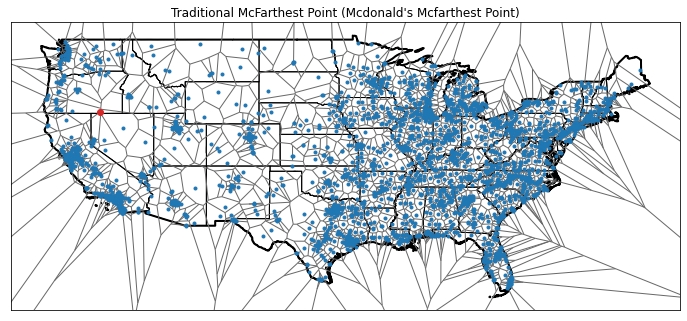

In [26]:
fig, ax = plt.subplots(figsize = (12, 6), facecolor='white')
ax = plot_mcfarthest_result(
    mcdonalds_mcfarthest_results['us_mcfarthest_point'], 
    usa_lower_48, 
    mcdonalds_mcfarthest_results['voronoi_diagram'], 
    ax = ax
)
us_state_map.to_crs(4087).plot(ax = ax, color='None', edgecolor='k')
ax.set_title("Traditional McFarthest Point (Mcdonald's Mcfarthest Point)");

### McFarthest Points for Selected States

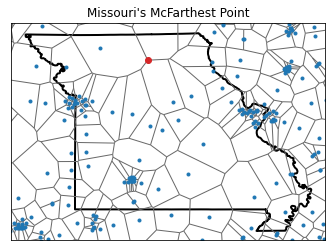

In [27]:
state_name = 'Missouri'
state_mcfarthest = mcdonalds_df_mcfarthest[mcdonalds_df_mcfarthest['state_name'] == state_name]['mcfarthest_coords'].iloc[0]
vor_state = mcdonalds_mcfarthest_results['voronoi_diagram']
fig, ax = plt.subplots(facecolor = 'white')
plot_single_state_mcfarthest(state_name, state_mcfarthest, vor_state, ax = ax);
ax.set_title("{}'s McFarthest Point".format(state_name));

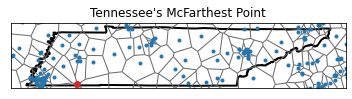

In [28]:
state_name = 'Tennessee'
state_mcfarthest = mcdonalds_df_mcfarthest[mcdonalds_df_mcfarthest['state_name'] == state_name]['mcfarthest_coords'].iloc[0]
vor_state = mcdonalds_mcfarthest_results['voronoi_diagram']
fig, ax = plt.subplots(facecolor = 'white')
plot_single_state_mcfarthest(state_name, state_mcfarthest, vor_state, ax = ax);
ax.set_title("{}'s McFarthest Point".format(state_name));

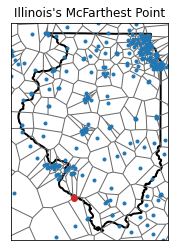

In [29]:
state_name = 'Illinois'
state_mcfarthest = mcdonalds_df_mcfarthest[mcdonalds_df_mcfarthest['state_name'] == state_name]['mcfarthest_coords'].iloc[0]
vor_state = mcdonalds_mcfarthest_results['voronoi_diagram']
fig, ax = plt.subplots(facecolor = 'white')
plot_single_state_mcfarthest(state_name, state_mcfarthest, vor_state, ax = ax);
ax.set_title("{}'s McFarthest Point".format(state_name));

## Note: pretty much inexplicably, it really is Illinois's. Grammar is dumb... see below:
# https://www.chicagomanualofstyle.org/qanda/data/faq/topics/PossessivesandAttributives/faq0046.html

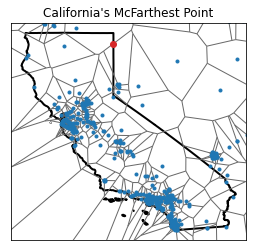

In [30]:
state_name = 'California'
state_mcfarthest = mcdonalds_df_mcfarthest[mcdonalds_df_mcfarthest['state_name'] == state_name]['mcfarthest_coords'].iloc[0]
vor_state = mcdonalds_mcfarthest_results['voronoi_diagram']
fig, ax = plt.subplots(facecolor = 'white')
plot_single_state_mcfarthest(state_name, state_mcfarthest, vor_state, ax = ax);
ax.set_title("{}'s McFarthest Point".format(state_name));

### McFarthest Points for All Lower 48 States

In [31]:
# save csv with results, and print nation wide result
df_mcdconalds_mcfarthest = mcfarthest_summary_for_chain(mcdonalds_mcfarthest_results, "McDonald's")
df_mcdconalds_mcfarthest.to_csv("./output_nonsphere/Mcdonalds_McFarthest.csv", index=False)

# print results 
with pd.option_context('display.precision', 2):
    html = (df_mcdconalds_mcfarthest
            .set_index('region')
            .sort_values('max_distance_miles', ascending=False)
            .reset_index()
            .head(n = 5)
            .style
            .hide_index())
html

region,max_distance_miles,mcfarthest_lat,mcfarthest_lon,nearest_lat,nearest_lon
US,181.38,42.14,-119.14,39.56,-119.76
Oregon,181.38,42.14,-119.14,34.88,-92.11
Nevada,173.11,41.97,-119.07,32.96,-117.04
South Dakota,172.96,44.29,-100.70,41.23,-85.32
Utah,164.66,37.30,-110.17,33.22,-117.25


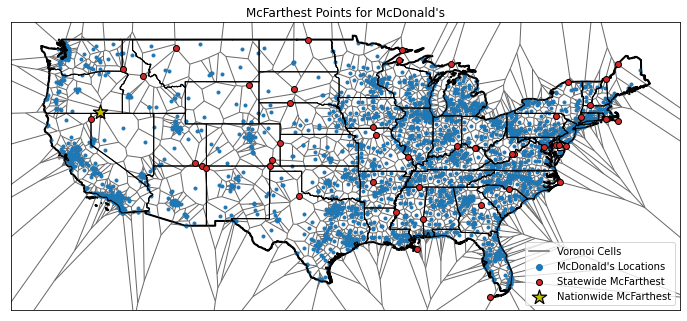

In [32]:
plot_mcfarthest_for_chain("McDonald's", mcdonalds_mcfarthest_results);

## Burger King's McFarthest Points

In [33]:
burgerking_mcfarthest_results = mcfarthest_for_chain('Burger King', fast_food_query_results, n_proc = n_proc)

In [34]:
# save csv with results, and print nation wide result
df_burgerking_mcfarthest = mcfarthest_summary_for_chain(burgerking_mcfarthest_results, "Burger King")
df_burgerking_mcfarthest.to_csv("./output_nonsphere/BurgerKing_McFarthest.csv", index=False)

# print results 
with pd.option_context('display.precision', 2):
    html = (df_burgerking_mcfarthest
            .set_index('region')
            .sort_values('max_distance_miles', ascending=False)
            .reset_index()
            .head(n = 5)
            .style
            .hide_index())
html

region,max_distance_miles,mcfarthest_lat,mcfarthest_lon,nearest_lat,nearest_lon
US,310.40,46.94,-112.98,42.57,-114.46
Montana,310.40,46.94,-112.98,42.27,-71.75
South Dakota,216.13,43.78,-102.43,33.19,-117.38
Idaho,214.85,46.41,-114.39,36.12,-115.21
Minnesota,213.16,48.63,-93.92,34.89,-92.11


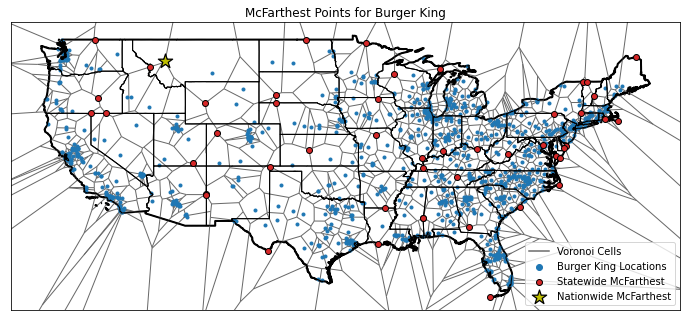

In [35]:
plot_mcfarthest_for_chain('Burger King', burgerking_mcfarthest_results);

## Wendy's McFarthest Points

In [36]:
wendys_mcfarthest_results = mcfarthest_for_chain("Wendy's", fast_food_query_results, n_proc = n_proc)

In [37]:
# save csv with results, and print nation wide result
df_wendys_mcfarthest = mcfarthest_summary_for_chain(wendys_mcfarthest_results, "Wendy's")
df_wendys_mcfarthest.to_csv("./output_nonsphere/Wendys_McFarthest.csv", index=False)

# print results 
with pd.option_context('display.precision', 2):
    html = (df_wendys_mcfarthest
            .set_index('region')
            .sort_values('max_distance_miles', ascending=False)
            .reset_index()
            .head(n = 5)
            .style
            .hide_index())
html

region,max_distance_miles,mcfarthest_lat,mcfarthest_lon,nearest_lat,nearest_lon
US,286.21,47.36,-68.23,43.51,-70.43
Maine,286.21,47.36,-68.23,35.09,-106.51
Montana,284.96,45.26,-112.35,33.39,-111.98
Texas,265.83,35.55,-100.93,33.11,-117.10
Wyoming,265.01,44.73,-109.28,40.20,-75.52


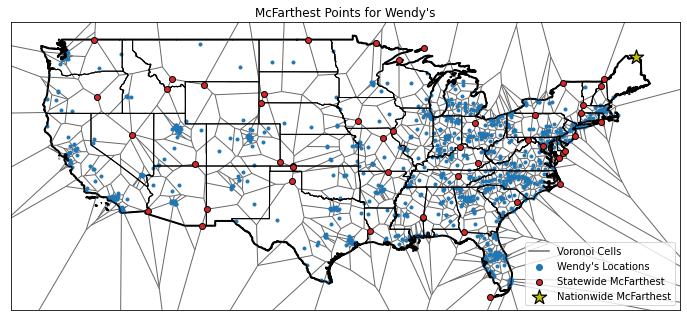

In [38]:
plot_mcfarthest_for_chain("Wendy's", wendys_mcfarthest_results);

## McFarthest Point Stability

In [39]:
fast_food_chain = "McDonald's"
unfiltered_latlons = fast_food_query_results[fast_food_chain]
ps, lats, lons = filter_and_transform_latlon_to_lower48(unfiltered_latlons, n_proc = n_proc)

In [40]:
%%time

bufs = []
ims = [] 

# we'll re-draw on the same figure
fig, ax = plt.subplots(facecolor = 'white', figsize = (12, 6))

# prepare the figures for animation
for n_ps in range(3, len(ps), 50):
    # compute the mcfarthest using only n_ps points 
    max_distance, mcfarthest, nearest_pt, vor = mcfarthest_in_poly(ps[0:n_ps, :], usa_lower_48_geom, n_proc = n_proc)

    # draw the image
    plt.cla()
    plot_mcfarthest_result(mcfarthest, usa_lower_48, vor, ax = ax)
    ax.set_title("McFarthest Point for {} using {}/{} Locations".format(fast_food_chain, n_ps, len(ps)))
    
    # write the image to a buffer to feed to 
    # PIL on in-RAM buffer: https://stackoverflow.com/a/8598881
    buf = io.BytesIO()    
    plt.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    im = Image.open(buf)
    
    # add im to list of ims
    ims.append(im)

# animate the result
gif_duration_seconds = 10
ims[0].save("./output_nonsphere/mcfarthest_stability.gif", save_all=True, append_images=ims[1:], optimize=True, 
            duration=(gif_duration_seconds * 1000) / len(ims), loop=0, quality = 50)

# close figure to avoid displaying it
plt.close(fig)

# release the buffers
for buf in bufs:
    buf.close()

CPU times: user 55.4 s, sys: 10 s, total: 1min 5s
Wall time: 1min 53s


In [41]:
# decrease file size if ImageMagick is present
if shutil.which('mogrify') is not None:
    os.system("mogrify -layers 'optimize' -fuzz 7% ./output_nonsphere/mcfarthest_stability.gif")

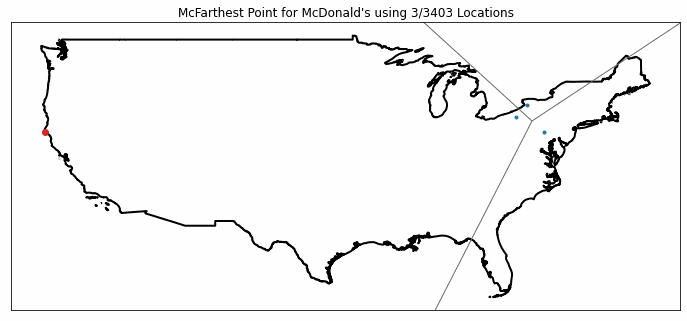

In [42]:
IPython.display.Image("./output_nonsphere/mcfarthest_stability.gif")